In [1]:
import os
import sys

path_to_repo = os.path.dirname(os.getcwd())
sys.path.append(path_to_repo)

import sklearn.datasets
import pandas as pd
import numpy as np

import sklearn.model_selection
from sklearn.metrics import r2_score, accuracy_score
#from imodels import FIGSRegressor, FIGSClassifier
#from imodels.importance import RandomForestPlusRegressor

import openml
from ucimlrepo import fetch_ucirepo 

from figs_d import *
from fourierDistill import *
from binary_mapper import *

In [2]:
def traverse_paths(node):
    if node is None:
        return []

    paths = []
    vals = []

    def dfs(current, path, from_left=False):
        if current.left is None and current.right is None and not from_left:
            paths.append(path.copy())
            vals.append(current.value.item())
            return 
        
        if current.left:
            dfs(current.left, [], from_left=True)

        if current.right:
            path.append(current)
            dfs(current.right, path)

    dfs(node, [])

    return list(zip(paths, vals))

In [3]:
miami_housing = openml.datasets.get_dataset(43093)
X, y, _, _ = miami_housing.get_data(target=miami_housing.default_target_attribute, dataset_format="dataframe")

/tmp/ipykernel_29445/2913580745.py:1: FutureWarning: Starting from Version 0.15 `download_data`, `download_qualities`, and `download_features_meta_data` will all be ``False`` instead of ``True`` by default to enable lazy loading. To disable this message until version 0.15 explicitly set `download_data`, `download_qualities`, and `download_features_meta_data` to a bool while calling `get_dataset`.
  miami_housing = openml.datasets.get_dataset(43093)
/home/mattyshen/anaconda3/lib/python3.9/site-packages/pandas/core/frame.py:717: DeprecationWarning: Passing a BlockManager to DataFrame is deprecated and will raise in a future version. Use public APIs instead.
  warnings.warn(


In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=0)

In [5]:
gmm_bm = GMMBinaryMapper()

#X_f, X_nf, y_f, y_nf = train_test_split(X_train, y_train, test_size=0.5, random_state=0)

gmm_bm.fit(X_train, y_train)

X_train_new = gmm_bm.transform(X_train)
X_val_new = gmm_bm.transform(X_val)

In [6]:
ftd = FTDistillRegressorCV(pre_interaction=None, post_max_features=10)
ftd.fit(X_train_new, y_train)

In [7]:
figs = FIGSRegressor(max_rules = 17, max_trees = 10)
figs.fit(X_train_new, y_train, feature_names = list(X_train_new.columns))

FIGSRegressor(max_rules=17, max_trees=10)

In [8]:
len(figs.trees_)

5

In [9]:
figs_rules = [traverse_paths(t) for t in figs.trees_]

In [10]:
figs_rules

[[([TOT_LVG_AREA_region4 <= 0.500 (Tree #0 root)], 1091855.7534246575)],
 [([TOT_LVG_AREA_region4 <= 0.500 (split)], -443142.6554331277),
  ([SUBCNTR_DI_region1 <= 0.500 (split), OCEAN_DIST_region1 <= 0.500 (split)],
   180534.3197198224),
  ([SUBCNTR_DI_region1 <= 0.500 (split)], 346661.0732832696),
  ([CNTR_DIST_region1 <= 0.500 (split)], 774560.2698056065),
  ([structure_quality_5 <= 0.500 (Tree #1 root),
    OCEAN_DIST_region1 <= 0.500 (split),
    SPEC_FEAT_VAL_region1 <= 0.500 (split)],
   358546.01091775444)],
 [([TOT_LVG_AREA_region1 <= 0.500 (split)], -89750.23672620118),
  ([TOT_LVG_AREA_region3 <= 0.500 (Tree #2 root),
    LATITUDE_region3 <= 0.500 (split),
    SUBCNTR_DI_region1 <= 0.500 (split)],
   628521.2255317793)],
 [([PARCELNO_region2 <= 0.500 (split), HWY_DIST_region4 <= 0.500 (split)],
   568362.1081272365),
  ([structure_quality_2 <= 0.500 (Tree #3 root)], -49447.51132687485)],
 [([structure_quality_3 <= 0.500 (Tree #4 root)], 760738.8834760431)]]

In [11]:
figs_rules = [
    x
    for xs in figs_rules
    for x in xs
]

In [12]:
len(figs_rules)

11

In [13]:
figs_rules

[([TOT_LVG_AREA_region4 <= 0.500 (Tree #0 root)], 1091855.7534246575),
 ([TOT_LVG_AREA_region4 <= 0.500 (split)], -443142.6554331277),
 ([SUBCNTR_DI_region1 <= 0.500 (split), OCEAN_DIST_region1 <= 0.500 (split)],
  180534.3197198224),
 ([SUBCNTR_DI_region1 <= 0.500 (split)], 346661.0732832696),
 ([CNTR_DIST_region1 <= 0.500 (split)], 774560.2698056065),
 ([structure_quality_5 <= 0.500 (Tree #1 root),
   OCEAN_DIST_region1 <= 0.500 (split),
   SPEC_FEAT_VAL_region1 <= 0.500 (split)],
  358546.01091775444),
 ([TOT_LVG_AREA_region1 <= 0.500 (split)], -89750.23672620118),
 ([TOT_LVG_AREA_region3 <= 0.500 (Tree #2 root),
   LATITUDE_region3 <= 0.500 (split),
   SUBCNTR_DI_region1 <= 0.500 (split)],
  628521.2255317793),
 ([PARCELNO_region2 <= 0.500 (split), HWY_DIST_region4 <= 0.500 (split)],
  568362.1081272365),
 ([structure_quality_2 <= 0.500 (Tree #3 root)], -49447.51132687485),
 ([structure_quality_3 <= 0.500 (Tree #4 root)], 760738.8834760431)]

In [14]:
paths = []
weights = []
for path, weight in figs_rules:
    cur_path = []
    for stop in path:
        cur_path.append(stop.feature_names[stop.feature])
    paths.append(tuple(cur_path))
    weights.append(weight)

In [16]:
figs_int = sorted(paths, key=lambda x: (len(x), x[0].lower()))

In [17]:
ftd_int = sorted(list(ftd.post_interaction_features), key=lambda x: (len(x), x[0].lower()))

In [18]:
[sorted(f) for f in figs_int]

[['CNTR_DIST_region1'],
 ['structure_quality_2'],
 ['structure_quality_3'],
 ['SUBCNTR_DI_region1'],
 ['TOT_LVG_AREA_region1'],
 ['TOT_LVG_AREA_region4'],
 ['TOT_LVG_AREA_region4'],
 ['HWY_DIST_region4', 'PARCELNO_region2'],
 ['OCEAN_DIST_region1', 'SUBCNTR_DI_region1'],
 ['OCEAN_DIST_region1', 'SPEC_FEAT_VAL_region1', 'structure_quality_5'],
 ['LATITUDE_region3', 'SUBCNTR_DI_region1', 'TOT_LVG_AREA_region3']]

In [19]:
[sorted(f) for f in ftd_int]

[['TOT_LVG_AREA_region1'],
 ['CNTR_DIST_region2', 'TOT_LVG_AREA_region3'],
 ['OCEAN_DIST_region1', 'SUBCNTR_DI_region1'],
 ['TOT_LVG_AREA_region4', 'structure_quality_4'],
 ['CNTR_DIST_region1', 'SPEC_FEAT_VAL_region4', 'avno60plus_0'],
 ['OCEAN_DIST_region1', 'PARCELNO_region2', 'SUBCNTR_DI_region2'],
 ['CNTR_DIST_region1', 'SPEC_FEAT_VAL_region3', 'avno60plus_0'],
 ['OCEAN_DIST_region1', 'WATER_DIST_region1', 'structure_quality_5'],
 ['TOT_LVG_AREA_region4', 'avno60plus_0', 'structure_quality_5']]

In [83]:
for t in figs_int:
    for f in ftd_int:
        if t==f:
            print(t)

('TOT_LVG_AREA_region1',)
('SUBCNTR_DI_region1', 'OCEAN_DIST_region1')


In [21]:
flat_figs_int = [s for t in figs_int for s in t]
flat_ftd_int = [s for t in ftd_int for s in t]
print(f'FIGS unique: {sorted(list(set(flat_figs_int)))}')
print(f'FT Distill unique: {sorted(list(set(flat_ftd_int)))}')

FIGS unique: ['CNTR_DIST_region1', 'HWY_DIST_region4', 'LATITUDE_region3', 'OCEAN_DIST_region1', 'PARCELNO_region2', 'SPEC_FEAT_VAL_region1', 'SUBCNTR_DI_region1', 'TOT_LVG_AREA_region1', 'TOT_LVG_AREA_region3', 'TOT_LVG_AREA_region4', 'structure_quality_2', 'structure_quality_3', 'structure_quality_5']
FT Distill unique: ['CNTR_DIST_region1', 'CNTR_DIST_region2', 'OCEAN_DIST_region1', 'PARCELNO_region2', 'SPEC_FEAT_VAL_region3', 'SPEC_FEAT_VAL_region4', 'SUBCNTR_DI_region1', 'SUBCNTR_DI_region2', 'TOT_LVG_AREA_region1', 'TOT_LVG_AREA_region3', 'TOT_LVG_AREA_region4', 'WATER_DIST_region1', 'avno60plus_0', 'structure_quality_4', 'structure_quality_5']


In [22]:
from sklearn.metrics import r2_score

In [23]:
print(r2_score(y_val, ftd.predict(X_val_new)))
print(r2_score(y_val, figs.predict(X_val_new)))

0.6875009011481434
0.7423219195628676


In [24]:
print(r2_score(y_train, ftd.predict(X_train_new)))
print(r2_score(y_train, figs.predict(X_train_new)))

0.7354711268413527
0.7727836067711333


In [25]:
len(sorted(list(set(flat_figs_int))))

13

In [26]:
len(sorted(list(set(flat_ftd_int))))

15

In [27]:
len(list(set(flat_figs_int + flat_ftd_int)))

20

In [28]:
set(flat_figs_int) - set.intersection(set(flat_figs_int), set(flat_ftd_int))

{'HWY_DIST_region4',
 'LATITUDE_region3',
 'SPEC_FEAT_VAL_region1',
 'structure_quality_2',
 'structure_quality_3'}

In [30]:
len(set(flat_figs_int))

13

In [31]:
set.intersection(set(flat_figs_int), set(flat_ftd_int))

{'CNTR_DIST_region1',
 'OCEAN_DIST_region1',
 'PARCELNO_region2',
 'SUBCNTR_DI_region1',
 'TOT_LVG_AREA_region1',
 'TOT_LVG_AREA_region3',
 'TOT_LVG_AREA_region4',
 'structure_quality_5'}

Text(0.5, 1.0, 'Correlation Matrix of GMM BM miami_housing Dataset')

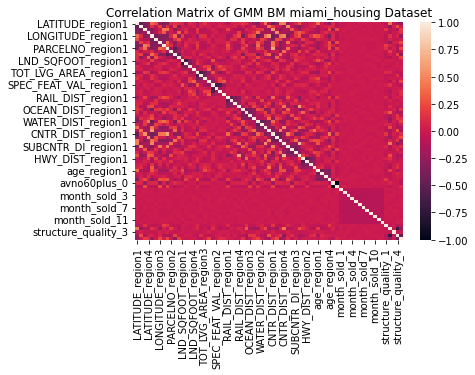

In [49]:
import seaborn as sns

corr = X_train_new.corr()

# plot the heatmap
sns.heatmap(corr)

plt.title('Correlation Matrix of GMM BM miami_housing Dataset')
#plt.savefig('figs/corr.png', bbox_inches='tight')

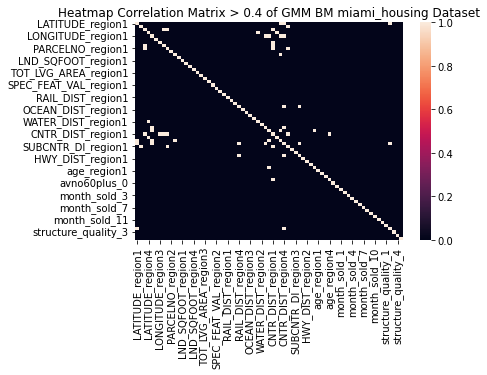

In [95]:
cor=0.4
sns.heatmap(corr > cor)
plt.title(f'Heatmap Correlation Matrix > {cor} of GMM BM miami_housing Dataset')
plt.savefig(f'figs/corr_{cor}.png', bbox_inches='tight')

In [68]:
corr_list = [(X_train_new.columns[t[0]], X_train_new.columns[t[1]]) for t in zip(np.where(corr > cor)[0], np.where(corr > cor)[1]) if t[0] < t[1]]

In [69]:
corr_list = sorted(corr_list, key= lambda x: x[0])
corr_list

[('CNTR_DIST_region1', 'SUBCNTR_DI_region1'),
 ('CNTR_DIST_region1', 'age_region4'),
 ('CNTR_DIST_region4', 'SUBCNTR_DI_region4'),
 ('CNTR_DIST_region4', 'structure_quality_2'),
 ('LATITUDE_region1', 'CNTR_DIST_region3'),
 ('LATITUDE_region1', 'CNTR_DIST_region4'),
 ('LATITUDE_region1', 'structure_quality_2'),
 ('LATITUDE_region2', 'SUBCNTR_DI_region1'),
 ('LATITUDE_region3', 'LONGITUDE_region4'),
 ('LATITUDE_region3', 'PARCELNO_region1'),
 ('LATITUDE_region3', 'CNTR_DIST_region1'),
 ('LATITUDE_region4', 'WATER_DIST_region1'),
 ('LATITUDE_region4', 'CNTR_DIST_region2'),
 ('LONGITUDE_region1', 'WATER_DIST_region3'),
 ('LONGITUDE_region1', 'WATER_DIST_region4'),
 ('LONGITUDE_region1', 'CNTR_DIST_region3'),
 ('LONGITUDE_region1', 'CNTR_DIST_region4'),
 ('LONGITUDE_region3', 'CNTR_DIST_region1'),
 ('LONGITUDE_region4', 'CNTR_DIST_region1'),
 ('PARCELNO_region1', 'CNTR_DIST_region1'),
 ('PARCELNO_region1', 'SUBCNTR_DI_region1'),
 ('PARCELNO_region3', 'CNTR_DIST_region3'),
 ('RAIL_DIST_regio

In [84]:
corr_dict_list = [{t1:t2} for t1, t2 in corr_list]
corr_dict_list

[{'CNTR_DIST_region1': 'SUBCNTR_DI_region1'},
 {'CNTR_DIST_region1': 'age_region4'},
 {'CNTR_DIST_region4': 'SUBCNTR_DI_region4'},
 {'CNTR_DIST_region4': 'structure_quality_2'},
 {'LATITUDE_region1': 'CNTR_DIST_region3'},
 {'LATITUDE_region1': 'CNTR_DIST_region4'},
 {'LATITUDE_region1': 'structure_quality_2'},
 {'LATITUDE_region2': 'SUBCNTR_DI_region1'},
 {'LATITUDE_region3': 'LONGITUDE_region4'},
 {'LATITUDE_region3': 'PARCELNO_region1'},
 {'LATITUDE_region3': 'CNTR_DIST_region1'},
 {'LATITUDE_region4': 'WATER_DIST_region1'},
 {'LATITUDE_region4': 'CNTR_DIST_region2'},
 {'LONGITUDE_region1': 'WATER_DIST_region3'},
 {'LONGITUDE_region1': 'WATER_DIST_region4'},
 {'LONGITUDE_region1': 'CNTR_DIST_region3'},
 {'LONGITUDE_region1': 'CNTR_DIST_region4'},
 {'LONGITUDE_region3': 'CNTR_DIST_region1'},
 {'LONGITUDE_region4': 'CNTR_DIST_region1'},
 {'PARCELNO_region1': 'CNTR_DIST_region1'},
 {'PARCELNO_region1': 'SUBCNTR_DI_region1'},
 {'PARCELNO_region3': 'CNTR_DIST_region3'},
 {'RAIL_DIST_regio

In [70]:
corr_dict = {}
for t1, t2 in corr_list:
    corr_dict[t1] = t2
corr_dict

{'CNTR_DIST_region1': 'age_region4',
 'CNTR_DIST_region4': 'structure_quality_2',
 'LATITUDE_region1': 'structure_quality_2',
 'LATITUDE_region2': 'SUBCNTR_DI_region1',
 'LATITUDE_region3': 'CNTR_DIST_region1',
 'LATITUDE_region4': 'CNTR_DIST_region2',
 'LONGITUDE_region1': 'CNTR_DIST_region4',
 'LONGITUDE_region3': 'CNTR_DIST_region1',
 'LONGITUDE_region4': 'CNTR_DIST_region1',
 'PARCELNO_region1': 'SUBCNTR_DI_region1',
 'PARCELNO_region3': 'CNTR_DIST_region3',
 'RAIL_DIST_region4': 'SUBCNTR_DI_region4',
 'WATER_DIST_region3': 'CNTR_DIST_region4',
 'WATER_DIST_region4': 'HWY_DIST_region4'}

In [97]:
# def apply_dict_to_list_of_lists(list_of_lists, replace_dict):
#     return [[replace_dict.get(item, item) for item in sublist] for sublist in list_of_lists]
def apply_dict_to_list_of_lists(list_of_lists, replace_dict_list, i=-1):
    return [[[d.get(item, item) for d in replace_dict_list][i] for item in sublist] for sublist in list_of_lists]

# # Apply the function
# ftd_int_corr = apply_dict_to_list_of_lists(ftd_int, corr_dict)
# figs_int_corr = apply_dict_to_list_of_lists(figs_int, corr_dict)

# ftd_int_corr

ftd_int_corr = apply_dict_to_list_of_lists(ftd_int, corr_dict_list)
figs_int_corr = apply_dict_to_list_of_lists(figs_int, corr_dict_list)

ftd_int_corr

[['TOT_LVG_AREA_region1'],
 ['CNTR_DIST_region2', 'TOT_LVG_AREA_region3'],
 ['SUBCNTR_DI_region1', 'OCEAN_DIST_region1'],
 ['TOT_LVG_AREA_region4', 'structure_quality_4'],
 ['CNTR_DIST_region1', 'avno60plus_0', 'SPEC_FEAT_VAL_region4'],
 ['PARCELNO_region2', 'SUBCNTR_DI_region2', 'OCEAN_DIST_region1'],
 ['SPEC_FEAT_VAL_region3', 'CNTR_DIST_region1', 'avno60plus_0'],
 ['structure_quality_5', 'WATER_DIST_region1', 'OCEAN_DIST_region1'],
 ['TOT_LVG_AREA_region4', 'structure_quality_5', 'avno60plus_0']]

In [100]:
for i in range(len(corr_dict_list)):
    ftd_int_corr = apply_dict_to_list_of_lists(ftd_int, corr_dict_list, i)
    figs_int_corr = apply_dict_to_list_of_lists(figs_int, corr_dict_list, i)
    print(f'num overlapped interactions: {sum([x == y for x in figs_int_corr for y in ftd_int_corr])}')

num overlapped interactions: 2
num overlapped interactions: 2
num overlapped interactions: 2
num overlapped interactions: 2
num overlapped interactions: 2
num overlapped interactions: 2
num overlapped interactions: 2
num overlapped interactions: 2
num overlapped interactions: 2
num overlapped interactions: 2
num overlapped interactions: 2
num overlapped interactions: 2
num overlapped interactions: 2
num overlapped interactions: 2
num overlapped interactions: 2
num overlapped interactions: 2
num overlapped interactions: 2
num overlapped interactions: 2
num overlapped interactions: 2
num overlapped interactions: 2
num overlapped interactions: 2
num overlapped interactions: 2
num overlapped interactions: 2
num overlapped interactions: 2
num overlapped interactions: 2
num overlapped interactions: 2
num overlapped interactions: 2


In [93]:
print(f'num overlapped interactions: {sum([x == y for x in figs_int_corr for y in ftd_int_corr])}')

num overlapped interactions: 2


In [94]:
for t in figs_int_corr:
    for f in ftd_int_corr:
        if t==f:
            print(t)

['TOT_LVG_AREA_region1']
['SUBCNTR_DI_region1', 'OCEAN_DIST_region1']
